# Zhiguang Guan
# 301216265

(1)

Import all the necessary libraries, read the dataset using pandas and analyze the data. 

For data preparation phase, save the “benign” and “attack” dataframe separately. 

Drop the “Label” column from the dataset and convert benign and attack dataframes to numpy arrays. 

Now, split the data into test and train (use 75% observations for train set and the remaining 25% for test set). 

Then, scale the train and test data using Standard Scalar. [10% marks].

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from numpy.random import seed
seed(1)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = pd.read_csv("network_attack_data.csv")

In [3]:
data.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [4]:
data_benign = data[data['Label']==0]
data_attack = data[data['Label']==1]

In [5]:
y_benign = data_benign['Label'].values
x_benign = data_benign.drop('Label',axis=1).values
y_attack = data_attack['Label'].values
x_attack = data_attack.drop('Label',axis=1).values

In [6]:
x_benign_train, x_benign_test= train_test_split(x_benign, test_size=0.25, random_state=40)

In [7]:
scaler=StandardScaler()
x_benign_train_scaled= scaler.fit_transform(x_benign_train) 
x_benign_test_scaled= scaler.transform(x_benign_test) 
x_attack_scaled= scaler.transform(x_attack)

(2)

Set the following hyperparameter values: [5% marks]. 

• batch_size = 32 

• original_dim = 76 

• latent_dim = 10 

• number of neurons in the hidden layers = 50 

• epochs = 100

In [8]:
batch_size = 32
original_dim = 76
latent_dim = 10
number_of_neurons_hidden_layers = 50
epochs = 100
epsilon_std = 1.0  

(3)

Using Keras Functional API, define the encoder, sampling layer, the decoder and instantiate the VAE model. Note both the encoder and decoder have two hidden layers each. [25% marks].

In [9]:
x = keras.layers.Input(shape=(original_dim,))
h1 = keras.layers.Dense(number_of_neurons_hidden_layers, activation='relu')(x)
h2 = keras.layers.Dense(number_of_neurons_hidden_layers, activation='relu')(h1)
z_mean = keras.layers.Dense(latent_dim)(h2)
z_log_var = keras.layers.Dense(latent_dim)(h2)

In [10]:
K = keras.backend
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [11]:
#Latent layer
z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) #latent_dim = 6

In [12]:
decoder_h1 = keras.layers.Dense(number_of_neurons_hidden_layers, activation='relu')
decoder_h2 = keras.layers.Dense(number_of_neurons_hidden_layers, activation='relu') 
h_decoded = decoder_h2(z)
decoder_mean = keras.layers.Dense(original_dim)
x_decoded_mean = decoder_mean(h_decoded)

In [13]:
vae = keras.models.Model(x, x_decoded_mean) #input and output for the VAE

(4)

Define the VAE loss function and compile the model using this loss metric and optimizer to be used is Adam. The learning rate value must be 0.001. [10% marks].

In [14]:
def vae_loss(feature, reconstructed): # VAE loss= Reconstruction loss + KL divergence
    reconstruction_loss = keras.losses.binary_crossentropy(feature, reconstructed)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

In [15]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=vae_loss)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           3850        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           510         dense_1[0][0]                    
______________________________________________________________________________________________

(5)

Train the model with batch_size and epochs set above. Display the loss curve during training. Then save the encoder, decoder and vae models (in .h5 format) using model.save. [15% marks].

In [16]:
history= vae.fit(x_benign_train_scaled, x_benign_train_scaled,verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2) #unsupervised learning because only x values used (no y values or labels)

Train on 13792 samples, validate on 3448 samples
Epoch 1/100
13792/13792 [==============================] - 3s 188us/sample - loss: -0.5260 - val_loss: -1.4580
Epoch 2/100
13792/13792 [==============================] - 1s 101us/sample - loss: -1.5836 - val_loss: -1.7403
Epoch 3/100
13792/13792 [==============================] - 1s 98us/sample - loss: -1.8355 - val_loss: -1.9364
Epoch 4/100
13792/13792 [==============================] - 1s 107us/sample - loss: -2.0098 - val_loss: -2.0840
Epoch 5/100
13792/13792 [==============================] - 1s 106us/sample - loss: -2.1129 - val_loss: -1.5741
Epoch 6/100
13792/13792 [==============================] - 2s 121us/sample - loss: -2.0290 - val_loss: -2.1504
Epoch 7/100
13792/13792 [==============================] - 2s 131us/sample - loss: -2.0556 - val_loss: -2.2035
Epoch 8/100
13792/13792 [==============================] - 2s 120us/sample - loss: -2.0401 - val_loss: -2.2313
Epoch 9/100
13792/13792 [==============================] - 2s 11

Epoch 74/100
13792/13792 [==============================] - 2s 142us/sample - loss: -2.3782 - val_loss: -2.4550
Epoch 75/100
13792/13792 [==============================] - 2s 137us/sample - loss: -2.3064 - val_loss: -2.1799
Epoch 76/100
13792/13792 [==============================] - 2s 147us/sample - loss: -2.3333 - val_loss: -2.4625
Epoch 77/100
13792/13792 [==============================] - 2s 152us/sample - loss: -2.4819 - val_loss: -2.2220
Epoch 78/100
13792/13792 [==============================] - 2s 147us/sample - loss: -2.2943 - val_loss: -2.4046
Epoch 79/100
13792/13792 [==============================] - 2s 148us/sample - loss: -2.5143 - val_loss: -2.5335
Epoch 80/100
13792/13792 [==============================] - 2s 152us/sample - loss: -2.4353 - val_loss: -2.5194
Epoch 81/100
13792/13792 [==============================] - 2s 154us/sample - loss: -2.4764 - val_loss: -2.5527
Epoch 82/100
13792/13792 [==============================] - 2s 147us/sample - loss: -2.4766 - val_loss: 

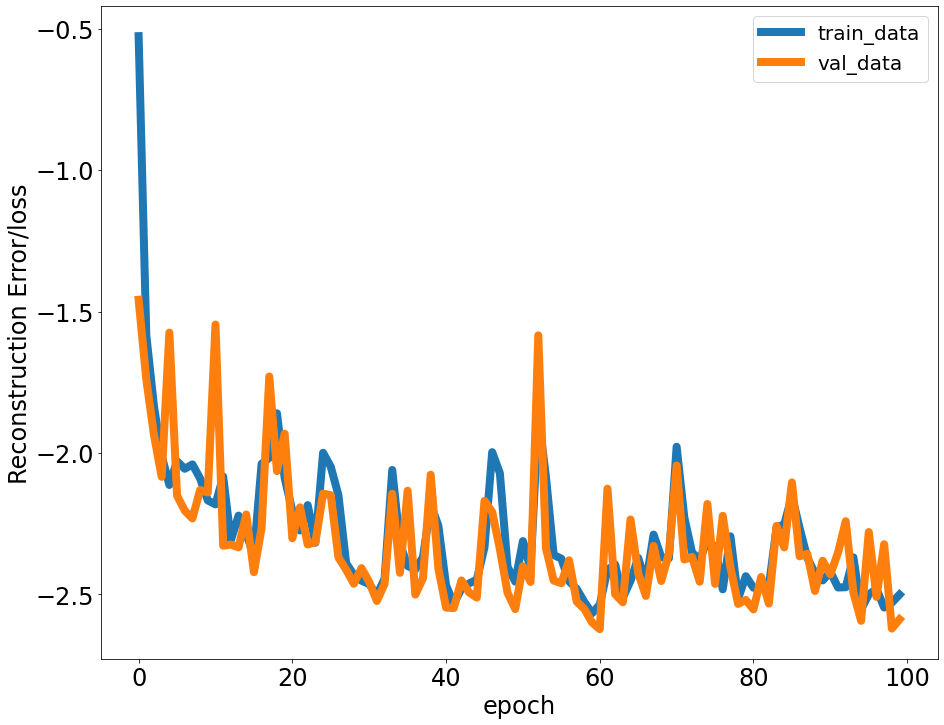

In [17]:
#a loss plot train-validation
import matplotlib as mpl
mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

In [18]:
# vae.save("vae.h5")

(6)

Make predictions on test data using model.predict, and visualize your plot comparing benign observations with attack observations. Select the most appropriate threshold value by observing the graph and using trial and error approach. [20% marks].

In [19]:
tst_obs = np.append(x_benign_test_scaled, x_attack_scaled, axis=0)
Y_obs  = np.append(y_benign[:x_benign_test_scaled.shape[0]], y_attack, axis=0)

In [20]:
test_preds=vae.predict(tst_obs)
mse_test = np.mean(np.power(tst_obs- test_preds, 2), axis=1)

In [21]:
tst_error_data = pd.DataFrame({'recon_error': mse_test,'Class': Y_obs})

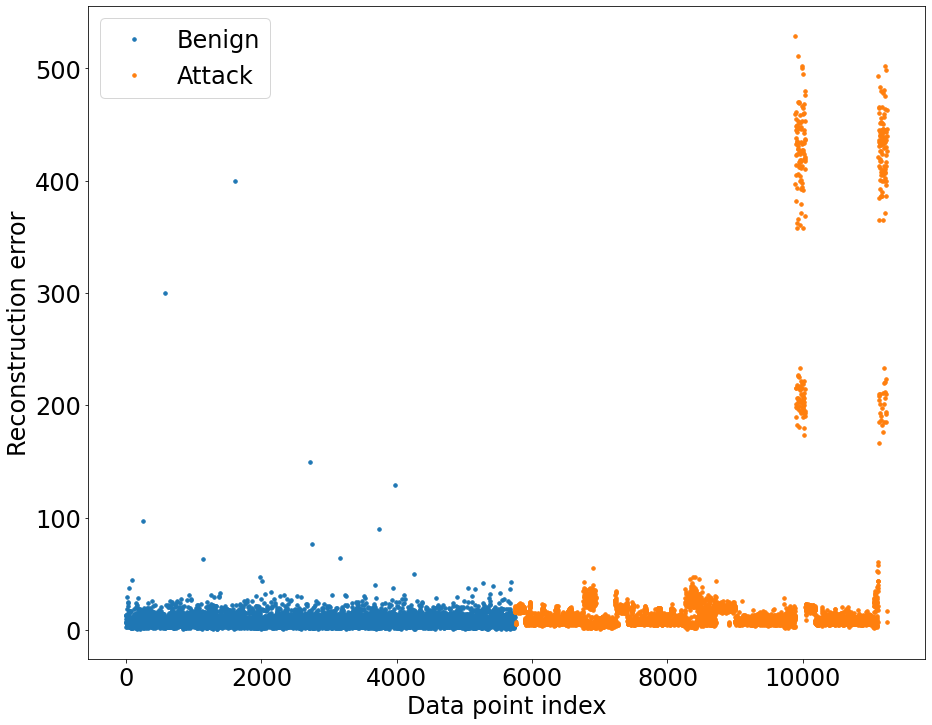

In [22]:
#####RE for different classes of data
group1 = tst_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "Benign")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

(7)

Perform the metric analysis to evaluate the performance of your classifier at your selected threshold. Display the results in terms of TPR, FPR, TNR, FNR, Precision, F1_score and ROC-AUC graph. [15% marks].

In [23]:
# Compute confusion matrix for test data (fraud+normal)
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

threshold=0.01 ##selected using trial and error

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))


Confusion matrix:
[[   0 5747]
 [   0 5498]]

Total number of true positives 5498
Total number of false negatives 0
Total number of false positives 5747
Total number of true negatives 0

Classifier Accuracy: 48.89%
True Positive Rate (TPR/Recall/Sensitivity): 100.00%
True Negative Rate (TNR/Specificity/selectivity):0.00%
False Positive Rate (FPR): 100.00%
False Negative Rate (FNR): 0.00%
Precision/Positive Predictive value:48.89%
F1-Score: 65.68%


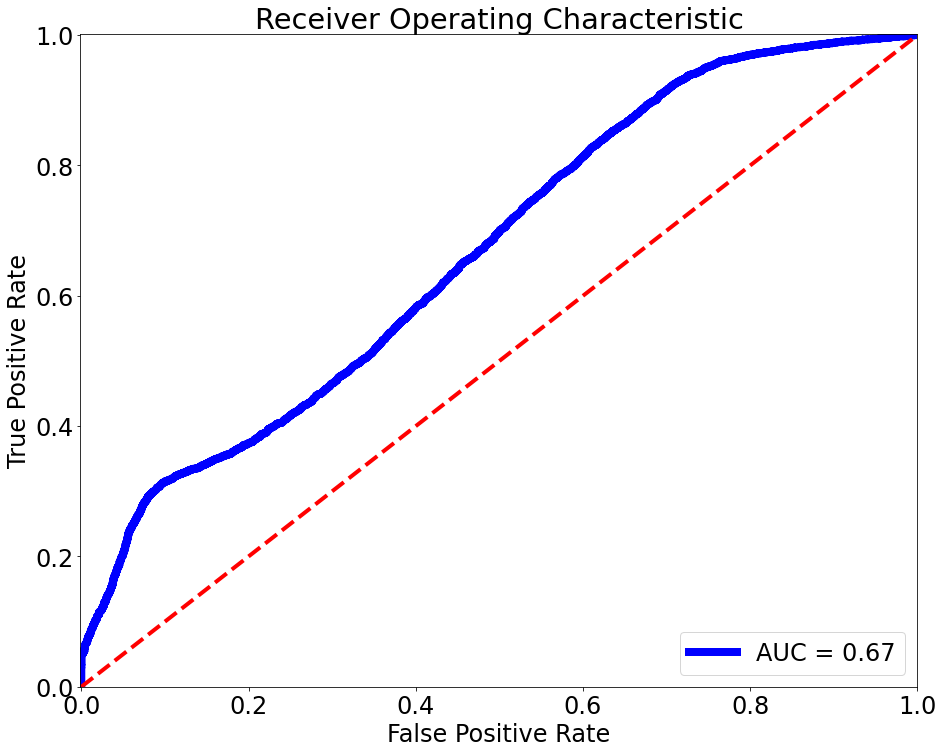

In [24]:
##########ROC GRAPH#######
fpr, tpr, thresholds = roc_curve(tst_error_data.Class,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()